In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, f1_score, precision_score, recall_score
import nltk
from sklearn.metrics import confusion_matrix


In [31]:
# Функция для предобработки текста 
## Осуществляет токенизацию текста и удаляет числа

def preprocess_text(text):
    if not isinstance(text, str):
        return ''  
    # Токенизация
    tokens = nltk.word_tokenize(text.lower())
    # Удаление стоп-слов 
    tokens = [word for word in tokens if word.isalpha()]
    return ' '.join(tokens)



In [33]:
# Функция для выделение контекста заданного размера из предложения 
## Находит слово-омограф в предложении и отделяет контекст нужной длины
import re

def extract_contexts(df, context_length):
 
    result_df = df.copy()
    result_df['context'] = None
    
    for idx, row in df.iterrows():
        keyword = row['Center']
        left_context = row['Left context']
        right_context = row['Right context']
        sentence = row['Full context']
        
        # Разбиваем контексты на слова
        left_context_words = left_context.split() if pd.notna(left_context) else []
        right_context_words = right_context.split() if pd.notna(right_context) else []
        
        # Получаем граничные слова контекстов
        last_left_word = left_context_words[-1] if left_context_words else ''
        first_right_word = right_context_words[0] if right_context_words else ''
        
        # Разбиваем предложение на слова (учитывая только буквенно-цифровые символы)
        sentence_words = re.findall(r'\b\w+\b', sentence)
        
        # Находим все позиции ключевого слова в предложении
        keyword_positions = [i for i, word in enumerate(sentence_words) if word == keyword]
        
        # Проверяем каждое вхождение ключевого слова
        for pos in keyword_positions:
            # Проверка левого контекста
            left_ok = True
            if left_context_words:
                if pos == 0:  
                    left_ok = False
                else:
                    left_word_in_sentence = sentence_words[pos - 1]
                    left_ok = (left_word_in_sentence == last_left_word)
            
            # Проверка правого контекста
            right_ok = True
            if right_context_words:
                if pos == len(sentence_words) - 1:  
                    right_ok = False
                else:
                    right_word_in_sentence = sentence_words[pos + 1]
                    right_ok = (right_word_in_sentence == first_right_word)
            
            # Если оба условия выполнены
            if left_ok and right_ok:
                # Вычисляем границы для извлечения
                start = max(0, pos - context_length)
                end = min(len(sentence_words), pos + context_length + 1)  # +1 чтобы включить ключевое слово
                
                # Извлекаем слова и объединяем в строку
                result_words = sentence_words[start:end]
                result_df.at[idx, 'context'] = ' '.join(result_words)
                break  # переходим к следующей строке после первого совпадения
    
    return result_df

In [11]:
# Функции - классификаторы 


# Логистическая регрессия
def logistic_regression(df, score, con_len):
    X_train, X_test, y_train, y_test = train_test_split(df['context'], df['Label'], test_size=0.3, random_state=42)

    # Векторизация текста с использованием TF-IDF
    vectorizer = TfidfVectorizer()
    X_train_tfidf = vectorizer.fit_transform(X_train)
    X_test_tfidf = vectorizer.transform(X_test)

    # Обучение логистической регрессии
    model = LogisticRegression()
    model.fit(X_train_tfidf, y_train)

    # Прогнозирование и оценка качества
    y_pred = model.predict(X_test_tfidf)
    print(classification_report(y_test, y_pred))
    score.at[int(con_len-1), 'accuracy'] = classification_report(y_test, y_pred, output_dict=True)['accuracy']
    score.at[con_len-1, 'weighted_average'] = classification_report(y_test, y_pred, output_dict=True)['weighted avg']

    cm = confusion_matrix(y_test, y_pred)
    print('Confusion matrix\n',cm)
    
   
# SVM Метод опопрных векторов
def svm_classification(df, score, con_len):
    X_train, X_test, y_train, y_test = train_test_split(
        df['context'], df['Label'], test_size=0.3, random_state=42
    )

    # Векторизация текста с использованием TF-IDF
    vectorizer = TfidfVectorizer()
    X_train_tfidf = vectorizer.fit_transform(X_train)
    X_test_tfidf = vectorizer.transform(X_test)

    # Обучение SVM-классификатора 
    model = SVC(kernel='linear', random_state=42)
    model.fit(X_train_tfidf, y_train)

    # Предсказания и оценка качества
    y_pred = model.predict(X_test_tfidf)
    print(classification_report(y_test, y_pred))
    score.at[int(con_len-1), 'accuracy'] = classification_report(y_test, y_pred, output_dict=True)['accuracy']
    score.at[con_len-1, 'weighted_average'] = classification_report(y_test, y_pred, output_dict=True)['weighted avg']

    cm = confusion_matrix(y_test, y_pred)
    print('Confusion matrix\n',cm)
    
    
# Random Forest classification
def rf_classification(df, score, con_len):
    X_train, X_test, y_train, y_test = train_test_split(
        df['context'], df['Label'], test_size=0.3, random_state=42
    )

    # Векторизация текста с использованием TF-IDF
    vectorizer = TfidfVectorizer()
    X_train_tfidf = vectorizer.fit_transform(X_train)
    X_test_tfidf = vectorizer.transform(X_test)

    # Обучение модели случайного леса
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X_train_tfidf, y_train)

    # Предсказания и оценка качества
    y_pred = model.predict(X_test_tfidf)
    print(classification_report(y_test, y_pred))
    score.at[int(con_len-1), 'accuracy'] = classification_report(y_test, y_pred, output_dict=True)['accuracy']
    score.at[con_len-1, 'weighted_average'] = classification_report(y_test, y_pred, output_dict=True)['weighted avg']

    cm = confusion_matrix(y_test, y_pred)
    print('Confusion matrix\n',cm)
    
    
# Ada Boost
from sklearn.ensemble import AdaBoostClassifier

def adaboost_classification(df, score, con_len):
    X_train, X_test, y_train, y_test = train_test_split(
        df['context'], df['Label'], test_size=0.3, random_state=42
    )

    # Векторизация текста с использованием TF-IDF
    vectorizer = TfidfVectorizer()
    X_train_tfidf = vectorizer.fit_transform(X_train)
    X_test_tfidf = vectorizer.transform(X_test)

    # Обучение AdaBoost-классификатора (используем базовый классификатор по умолчанию - DecisionTree)
    model = AdaBoostClassifier(n_estimators=50, random_state=42)
    model.fit(X_train_tfidf, y_train)

    # Предсказания и оценка качества
    y_pred = model.predict(X_test_tfidf)
    print(classification_report(y_test, y_pred))
    score.at[int(con_len-1), 'accuracy'] = classification_report(y_test, y_pred, output_dict=True)['accuracy']
    score.at[con_len-1, 'weighted_average'] = classification_report(y_test, y_pred, output_dict=True)['weighted avg']

    cm = confusion_matrix(y_test, y_pred)
    print('Confusion matrix\n',cm)

In [35]:
# Основная функция 
## Переменной context_length присваивается максимальное значение длины контекста. Затем на каждой итерации от 1 до context_length из предложений 
## датасета выделяется контекст омографа с длиной, равной номеру итерации (при помощи функции extract_contexts()), и производится классификация 
## омографов, затем оценивается качество проведенной классификации.
context_length = 30 # Максимальная длина контекста
def main(df, func):
    score = pd.DataFrame()
    score['context_length'] = None  
    score['accuracy'] = None
    score['weighted_average'] = None
    for i in range(1, context_length+1):
        df_contexts = extract_contexts(df,  i)
        score.at[i-1, 'context_length'] = i  
        print(f'Показатели для длины контекста', i)
        func(df_contexts,score, i)
    return score

In [15]:
# Чтение файла, предобработка текста     
        
df = pd.read_excel(r"C:\Users\tvn4175\лук_датасет_processed.xlsx", usecols=['Left context','Center','Punct','Label','Right context', 'Full context'])
print('\nData types of the columns:')
print(df.dtypes)
print(df['Label'].value_counts())

df['Left context'] = df['Left context'].apply(preprocess_text)
df['Right context'] = df['Right context'].apply(preprocess_text)
df['Full context'] = df['Full context'].apply(preprocess_text)
df['Center'] = df['Center'].apply(preprocess_text)



Data types of the columns:
Left context     object
Center           object
Punct            object
Label             int64
Right context    object
Full context     object
dtype: object
Label
1    311
2    300
Name: count, dtype: int64


In [37]:
df

,Left context,Center,Punct,Label,Right context,Full context
0,ущербный,лук,",",1,пистолеты с камерами ранее у,ущербный лук пистолеты с камерами ранее у блей...
1,опыт стрельбы из автомата и из,лука,",",1,не более так что я тут,у меня есть опыт стрельбы из автомата и из лук...
2,оч хочу пострелять из,лукаааа,!!!!,1,,оч хочу пострелять из лукаааа
3,после парашюта сразу пойти пострелять из,лука,.,1,,после парашюта сразу пойти пострелять из лука
4,можно пострелять из,лука,,1,во время прыжка,можно пострелять из лука во время прыжка
...,...,...,...,...,...,...
606,чрезвычайно высокой распространённости и попул...,лука,,2,среди своего населения,англия пожалуй была единственной в то время ст...
607,наше время чтобы научиться стрелять из,лука,,1,да к тому же попадать в,точно так же и в наше время чтобы научиться ст...
608,современный,лук,―,1,довольно сложный механизм который как и,современный лук довольно сложный механизм кото...
609,сути первое знакомство будущего спортсмена с,луком,,1,отчасти напоминает визит к портному,по сути первое знакомство будущего спортсмена ...


Logistic regression
Показатели для длины контекста 1
              precision    recall  f1-score   support

           1       0.71      0.82      0.76        88
           2       0.80      0.69      0.74        96

    accuracy                           0.75       184
   macro avg       0.76      0.75      0.75       184
weighted avg       0.76      0.75      0.75       184

Confusion matrix
 [[72 16]
 [30 66]]
Показатели для длины контекста 2
              precision    recall  f1-score   support

           1       0.77      0.88      0.82        88
           2       0.87      0.76      0.81        96

    accuracy                           0.82       184
   macro avg       0.82      0.82      0.82       184
weighted avg       0.82      0.82      0.81       184

Confusion matrix
 [[77 11]
 [23 73]]
Показатели для длины контекста 3
              precision    recall  f1-score   support

           1       0.72      0.90      0.80        88
           2       0.88      0.69      0.77 

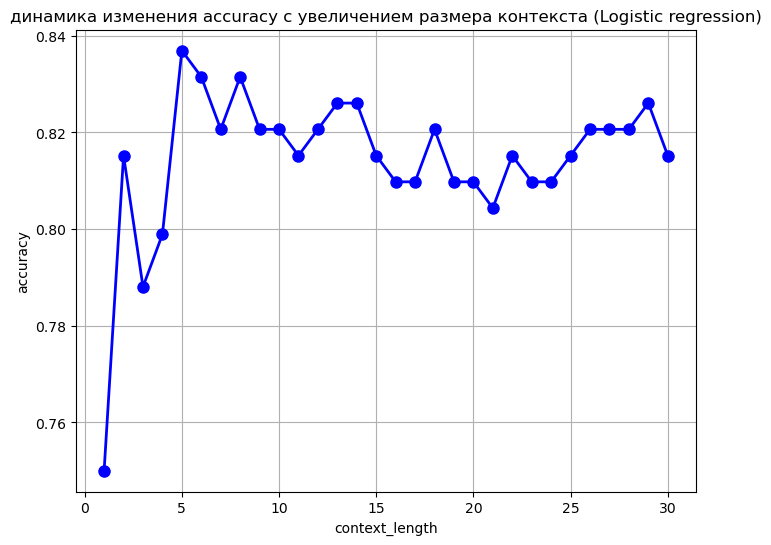

In [17]:
# Классификация омографов с использованием логистической регрессии

print('Logistic regression')
score_logistic_reg = main(df, logistic_regression)

# Строим график
plt.figure(figsize=(8, 6))
plt.plot(score_logistic_reg['context_length'], score_logistic_reg['accuracy'], 
         marker='o',  
         linestyle='-',  
         color='blue',
         linewidth=2,
         markersize=8)

# Подписи осей и заголовок
plt.xlabel('context_length')
plt.ylabel('accuracy')
plt.title('динамика изменения accuracy с увеличением размера контекста (Logistic regression)')
plt.grid(True)  

plt.show()

SVM classification
Показатели для длины контекста 1
              precision    recall  f1-score   support

           1       0.71      0.82      0.76        88
           2       0.81      0.70      0.75        96

    accuracy                           0.76       184
   macro avg       0.76      0.76      0.76       184
weighted avg       0.76      0.76      0.75       184

Confusion matrix
 [[72 16]
 [29 67]]
Показатели для длины контекста 2
              precision    recall  f1-score   support

           1       0.76      0.86      0.81        88
           2       0.86      0.75      0.80        96

    accuracy                           0.80       184
   macro avg       0.81      0.81      0.80       184
weighted avg       0.81      0.80      0.80       184

Confusion matrix
 [[76 12]
 [24 72]]
Показатели для длины контекста 3
              precision    recall  f1-score   support

           1       0.79      0.86      0.83        88
           2       0.86      0.79      0.83  

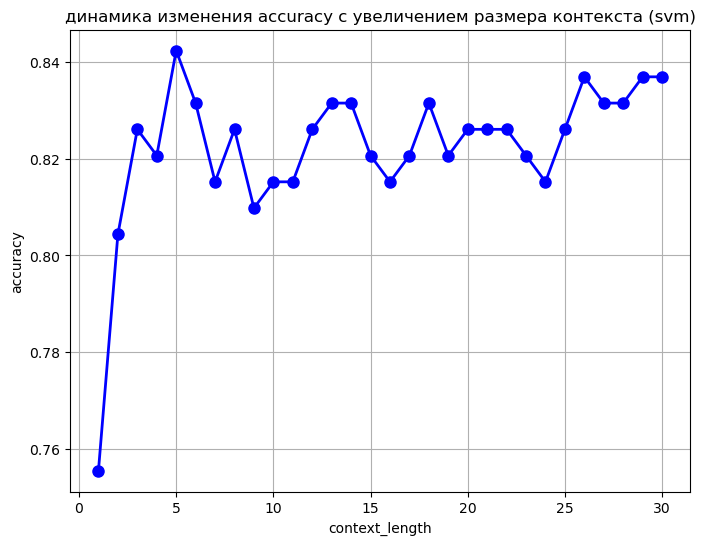

In [19]:
# Классификация омографов с использованием метода опорных векторов

print('SVM classification')
score_svm = main(df, svm_classification)
# Строим график
plt.figure(figsize=(8, 6))
plt.plot(score_svm['context_length'], score_svm['accuracy'], 
         marker='o',  
         linestyle='-',  
         color='blue',
         linewidth=2,
         markersize=8)

# Подписи осей и заголовок
plt.xlabel('context_length')
plt.ylabel('accuracy')
plt.title('динамика изменения accuracy с увеличением размера контекста (svm)')
plt.grid(True)  

plt.show()

Random Forest classification
Показатели для длины контекста 1
              precision    recall  f1-score   support

           1       0.63      0.88      0.73        88
           2       0.82      0.53      0.65        96

    accuracy                           0.70       184
   macro avg       0.73      0.70      0.69       184
weighted avg       0.73      0.70      0.69       184

Confusion matrix
 [[77 11]
 [45 51]]
Показатели для длины контекста 2
              precision    recall  f1-score   support

           1       0.63      0.90      0.74        88
           2       0.84      0.51      0.64        96

    accuracy                           0.70       184
   macro avg       0.74      0.70      0.69       184
weighted avg       0.74      0.70      0.69       184

Confusion matrix
 [[79  9]
 [47 49]]
Показатели для длины контекста 3
              precision    recall  f1-score   support

           1       0.65      0.90      0.75        88
           2       0.85      0.55  

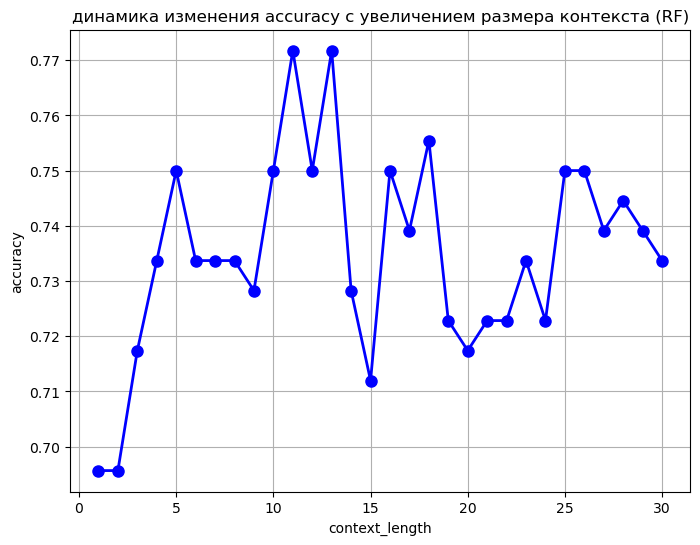

In [21]:
# Классификация омографов с использованием классификатора Random forest

print('Random Forest classification')
score_rf = main(df, rf_classification)
# Строим график
plt.figure(figsize=(8, 6))
plt.plot(score_rf['context_length'], score_rf['accuracy'], 
         marker='o',  
         linestyle='-',  
         color='blue',
         linewidth=2,
         markersize=8)

# Подписи осей и заголовок
plt.xlabel('context_length')
plt.ylabel('accuracy')
plt.title('динамика изменения accuracy с увеличением размера контекста (RF)')
plt.grid(True)  

plt.show()

Adaboost classification
Показатели для длины контекста 1
              precision    recall  f1-score   support

           1       0.71      0.81      0.76        88
           2       0.80      0.70      0.74        96

    accuracy                           0.75       184
   macro avg       0.75      0.75      0.75       184
weighted avg       0.76      0.75      0.75       184

Confusion matrix
 [[71 17]
 [29 67]]


C:\Users\tvn4175\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\tvn4175\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Показатели для длины контекста 2
              precision    recall  f1-score   support

           1       0.66      0.73      0.69        88
           2       0.72      0.66      0.69        96

    accuracy                           0.69       184
   macro avg       0.69      0.69      0.69       184
weighted avg       0.69      0.69      0.69       184

Confusion matrix
 [[64 24]
 [33 63]]
Показатели для длины контекста 3


C:\Users\tvn4175\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


              precision    recall  f1-score   support

           1       0.64      0.89      0.74        88
           2       0.84      0.54      0.66        96

    accuracy                           0.71       184
   macro avg       0.74      0.71      0.70       184
weighted avg       0.74      0.71      0.70       184

Confusion matrix
 [[78 10]
 [44 52]]
Показатели для длины контекста 4


C:\Users\tvn4175\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


              precision    recall  f1-score   support

           1       0.70      0.82      0.75        88
           2       0.80      0.68      0.73        96

    accuracy                           0.74       184
   macro avg       0.75      0.75      0.74       184
weighted avg       0.75      0.74      0.74       184

Confusion matrix
 [[72 16]
 [31 65]]
Показатели для длины контекста 5


C:\Users\tvn4175\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


              precision    recall  f1-score   support

           1       0.64      0.92      0.75        88
           2       0.88      0.52      0.65        96

    accuracy                           0.71       184
   macro avg       0.76      0.72      0.70       184
weighted avg       0.76      0.71      0.70       184

Confusion matrix
 [[81  7]
 [46 50]]
Показатели для длины контекста 6


C:\Users\tvn4175\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


              precision    recall  f1-score   support

           1       0.64      0.92      0.75        88
           2       0.88      0.52      0.65        96

    accuracy                           0.71       184
   macro avg       0.76      0.72      0.70       184
weighted avg       0.76      0.71      0.70       184

Confusion matrix
 [[81  7]
 [46 50]]
Показатели для длины контекста 7


C:\Users\tvn4175\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


              precision    recall  f1-score   support

           1       0.60      0.94      0.73        88
           2       0.89      0.43      0.58        96

    accuracy                           0.67       184
   macro avg       0.75      0.69      0.66       184
weighted avg       0.75      0.67      0.65       184

Confusion matrix
 [[83  5]
 [55 41]]
Показатели для длины контекста 8


C:\Users\tvn4175\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


              precision    recall  f1-score   support

           1       0.63      0.89      0.74        88
           2       0.84      0.53      0.65        96

    accuracy                           0.70       184
   macro avg       0.74      0.71      0.69       184
weighted avg       0.74      0.70      0.69       184

Confusion matrix
 [[78 10]
 [45 51]]
Показатели для длины контекста 9


C:\Users\tvn4175\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


              precision    recall  f1-score   support

           1       0.62      0.84      0.71        88
           2       0.78      0.53      0.63        96

    accuracy                           0.68       184
   macro avg       0.70      0.69      0.67       184
weighted avg       0.71      0.68      0.67       184

Confusion matrix
 [[74 14]
 [45 51]]
Показатели для длины контекста 10


C:\Users\tvn4175\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


              precision    recall  f1-score   support

           1       0.60      0.90      0.72        88
           2       0.83      0.46      0.59        96

    accuracy                           0.67       184
   macro avg       0.72      0.68      0.66       184
weighted avg       0.72      0.67      0.65       184

Confusion matrix
 [[79  9]
 [52 44]]
Показатели для длины контекста 11


C:\Users\tvn4175\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


              precision    recall  f1-score   support

           1       0.67      0.85      0.75        88
           2       0.82      0.61      0.70        96

    accuracy                           0.73       184
   macro avg       0.74      0.73      0.73       184
weighted avg       0.75      0.73      0.73       184

Confusion matrix
 [[75 13]
 [37 59]]
Показатели для длины контекста 12


C:\Users\tvn4175\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


              precision    recall  f1-score   support

           1       0.67      0.88      0.76        88
           2       0.84      0.60      0.70        96

    accuracy                           0.73       184
   macro avg       0.76      0.74      0.73       184
weighted avg       0.76      0.73      0.73       184

Confusion matrix
 [[77 11]
 [38 58]]
Показатели для длины контекста 13


C:\Users\tvn4175\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


              precision    recall  f1-score   support

           1       0.67      0.89      0.76        88
           2       0.85      0.59      0.70        96

    accuracy                           0.73       184
   macro avg       0.76      0.74      0.73       184
weighted avg       0.76      0.73      0.73       184

Confusion matrix
 [[78 10]
 [39 57]]
Показатели для длины контекста 14


C:\Users\tvn4175\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


              precision    recall  f1-score   support

           1       0.65      0.92      0.76        88
           2       0.88      0.54      0.67        96

    accuracy                           0.72       184
   macro avg       0.76      0.73      0.72       184
weighted avg       0.77      0.72      0.71       184

Confusion matrix
 [[81  7]
 [44 52]]
Показатели для длины контекста 15


C:\Users\tvn4175\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


              precision    recall  f1-score   support

           1       0.68      0.92      0.78        88
           2       0.89      0.59      0.71        96

    accuracy                           0.75       184
   macro avg       0.78      0.76      0.75       184
weighted avg       0.79      0.75      0.74       184

Confusion matrix
 [[81  7]
 [39 57]]
Показатели для длины контекста 16


C:\Users\tvn4175\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


              precision    recall  f1-score   support

           1       0.66      0.86      0.75        88
           2       0.83      0.59      0.69        96

    accuracy                           0.72       184
   macro avg       0.74      0.73      0.72       184
weighted avg       0.75      0.72      0.72       184

Confusion matrix
 [[76 12]
 [39 57]]
Показатели для длины контекста 17


C:\Users\tvn4175\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


              precision    recall  f1-score   support

           1       0.68      0.88      0.76        88
           2       0.84      0.61      0.71        96

    accuracy                           0.74       184
   macro avg       0.76      0.74      0.74       184
weighted avg       0.76      0.74      0.74       184

Confusion matrix
 [[77 11]
 [37 59]]
Показатели для длины контекста 18


C:\Users\tvn4175\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


              precision    recall  f1-score   support

           1       0.65      0.85      0.74        88
           2       0.81      0.58      0.68        96

    accuracy                           0.71       184
   macro avg       0.73      0.72      0.71       184
weighted avg       0.74      0.71      0.71       184

Confusion matrix
 [[75 13]
 [40 56]]
Показатели для длины контекста 19


C:\Users\tvn4175\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


              precision    recall  f1-score   support

           1       0.65      0.83      0.73        88
           2       0.79      0.59      0.68        96

    accuracy                           0.71       184
   macro avg       0.72      0.71      0.70       184
weighted avg       0.72      0.71      0.70       184

Confusion matrix
 [[73 15]
 [39 57]]
Показатели для длины контекста 20


C:\Users\tvn4175\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


              precision    recall  f1-score   support

           1       0.65      0.83      0.73        88
           2       0.79      0.58      0.67        96

    accuracy                           0.70       184
   macro avg       0.72      0.71      0.70       184
weighted avg       0.72      0.70      0.70       184

Confusion matrix
 [[73 15]
 [40 56]]
Показатели для длины контекста 21


C:\Users\tvn4175\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


              precision    recall  f1-score   support

           1       0.64      0.84      0.73        88
           2       0.80      0.57      0.67        96

    accuracy                           0.70       184
   macro avg       0.72      0.71      0.70       184
weighted avg       0.72      0.70      0.70       184

Confusion matrix
 [[74 14]
 [41 55]]
Показатели для длины контекста 22


C:\Users\tvn4175\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


              precision    recall  f1-score   support

           1       0.69      0.77      0.73        88
           2       0.76      0.68      0.72        96

    accuracy                           0.72       184
   macro avg       0.73      0.72      0.72       184
weighted avg       0.73      0.72      0.72       184

Confusion matrix
 [[68 20]
 [31 65]]
Показатели для длины контекста 23


C:\Users\tvn4175\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


              precision    recall  f1-score   support

           1       0.70      0.80      0.74        88
           2       0.79      0.69      0.73        96

    accuracy                           0.74       184
   macro avg       0.74      0.74      0.74       184
weighted avg       0.74      0.74      0.74       184

Confusion matrix
 [[70 18]
 [30 66]]
Показатели для длины контекста 24


C:\Users\tvn4175\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


              precision    recall  f1-score   support

           1       0.68      0.81      0.74        88
           2       0.79      0.66      0.72        96

    accuracy                           0.73       184
   macro avg       0.74      0.73      0.73       184
weighted avg       0.74      0.73      0.73       184

Confusion matrix
 [[71 17]
 [33 63]]
Показатели для длины контекста 25


C:\Users\tvn4175\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


              precision    recall  f1-score   support

           1       0.66      0.76      0.71        88
           2       0.74      0.64      0.69        96

    accuracy                           0.70       184
   macro avg       0.70      0.70      0.70       184
weighted avg       0.70      0.70      0.69       184

Confusion matrix
 [[67 21]
 [35 61]]
Показатели для длины контекста 26


C:\Users\tvn4175\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


              precision    recall  f1-score   support

           1       0.64      0.82      0.72        88
           2       0.78      0.58      0.67        96

    accuracy                           0.70       184
   macro avg       0.71      0.70      0.69       184
weighted avg       0.71      0.70      0.69       184

Confusion matrix
 [[72 16]
 [40 56]]
Показатели для длины контекста 27


C:\Users\tvn4175\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


              precision    recall  f1-score   support

           1       0.66      0.86      0.75        88
           2       0.83      0.59      0.69        96

    accuracy                           0.72       184
   macro avg       0.74      0.73      0.72       184
weighted avg       0.75      0.72      0.72       184

Confusion matrix
 [[76 12]
 [39 57]]
Показатели для длины контекста 28


C:\Users\tvn4175\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


              precision    recall  f1-score   support

           1       0.62      0.74      0.68        88
           2       0.71      0.59      0.65        96

    accuracy                           0.66       184
   macro avg       0.67      0.67      0.66       184
weighted avg       0.67      0.66      0.66       184

Confusion matrix
 [[65 23]
 [39 57]]
Показатели для длины контекста 29


C:\Users\tvn4175\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


              precision    recall  f1-score   support

           1       0.71      0.76      0.73        88
           2       0.76      0.71      0.74        96

    accuracy                           0.73       184
   macro avg       0.73      0.73      0.73       184
weighted avg       0.74      0.73      0.73       184

Confusion matrix
 [[67 21]
 [28 68]]
Показатели для длины контекста 30


C:\Users\tvn4175\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


              precision    recall  f1-score   support

           1       0.64      0.76      0.69        88
           2       0.73      0.60      0.66        96

    accuracy                           0.68       184
   macro avg       0.69      0.68      0.68       184
weighted avg       0.69      0.68      0.68       184

Confusion matrix
 [[67 21]
 [38 58]]


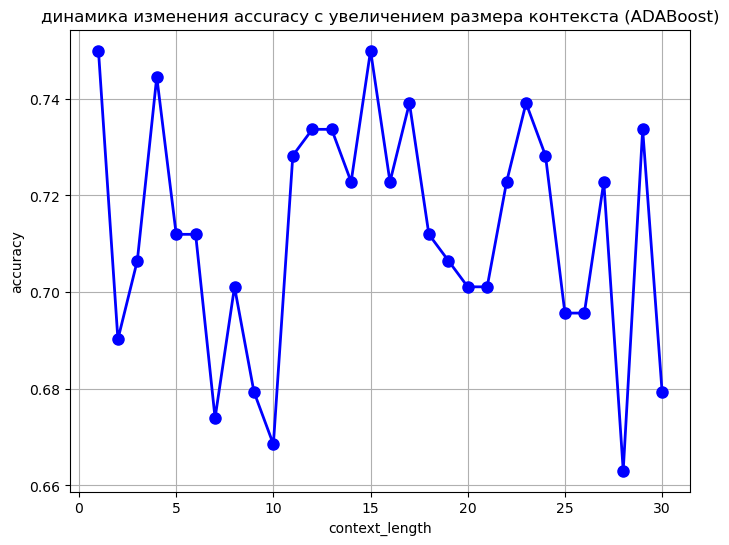

In [23]:
# Классификация омографов с использованием классификатора Adaboost

print('Adaboost classification')
score_adaboost = main(df, adaboost_classification)
# Строим график
plt.figure(figsize=(8, 6))
plt.plot(score_adaboost['context_length'], score_adaboost['accuracy'], 
         marker='o',  
         linestyle='-',  
         color='blue',
         linewidth=2,
         markersize=8)

# Подписи осей и заголовок
plt.xlabel('context_length')
plt.ylabel('accuracy')
plt.title('динамика изменения accuracy с увеличением размера контекста (ADABoost)')
plt.grid(True)  

plt.show()


In [27]:
# Функция для кластеризации с помощью метода K-means 

from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import silhouette_score, adjusted_rand_score
from sklearn.model_selection import train_test_split
import pandas as pd

def kmeans_clustering(df, score, con_len):
    X_train, X_test, y_train, y_test = train_test_split(
        df['context'], df['Label'], test_size=0.3, random_state=42
    )
    
    # Векторизация текста
    vectorizer = TfidfVectorizer()
    X_train_tfidf = vectorizer.fit_transform(X_train)
    X_test_tfidf = vectorizer.transform(X_test)
    
    # Определяем количество кластеров
    n_clusters = len(df['Label'].unique())  
    
    # Инициализация и обучение K-Means
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(X_train_tfidf)
    
    # Предсказание кластеров
    train_clusters = kmeans.predict(X_train_tfidf)
    test_clusters = kmeans.predict(X_test_tfidf)
    
    # Оценка качества кластеризации
    silhouette = silhouette_score(X_test_tfidf, test_clusters)
    ari = adjusted_rand_score(y_test, test_clusters)  # Сравнение с истинными метками
    
    print(f"\nОценки кластеризации для контекста длины {con_len}:")
    print(f"Silhouette Score: {silhouette:.4f}")
    print(f"Adjusted Rand Index: {ari:.4f}")
    
    # Запись результатов в датафрейм score
    score.at[int(con_len-1), 'silhouette'] = silhouette
    score.at[int(con_len-1), 'adjusted_rand'] = ari
    

K-means clustering
Показатели для длины контекста 1

Оценки кластеризации для контекста длины 1:
Silhouette Score: 0.2348
Adjusted Rand Index: 0.0531
Показатели для длины контекста 2

Оценки кластеризации для контекста длины 2:
Silhouette Score: 0.0503
Adjusted Rand Index: -0.0022
Показатели для длины контекста 3

Оценки кластеризации для контекста длины 3:
Silhouette Score: 0.0705
Adjusted Rand Index: 0.0094
Показатели для длины контекста 4

Оценки кластеризации для контекста длины 4:
Silhouette Score: 0.0481
Adjusted Rand Index: 0.0026
Показатели для длины контекста 5

Оценки кластеризации для контекста длины 5:
Silhouette Score: 0.0315
Adjusted Rand Index: 0.0181
Показатели для длины контекста 6

Оценки кластеризации для контекста длины 6:
Silhouette Score: 0.0239
Adjusted Rand Index: 0.0376
Показатели для длины контекста 7

Оценки кластеризации для контекста длины 7:
Silhouette Score: 0.0019
Adjusted Rand Index: 0.0037
Показатели для длины контекста 8

Оценки кластеризации для конт

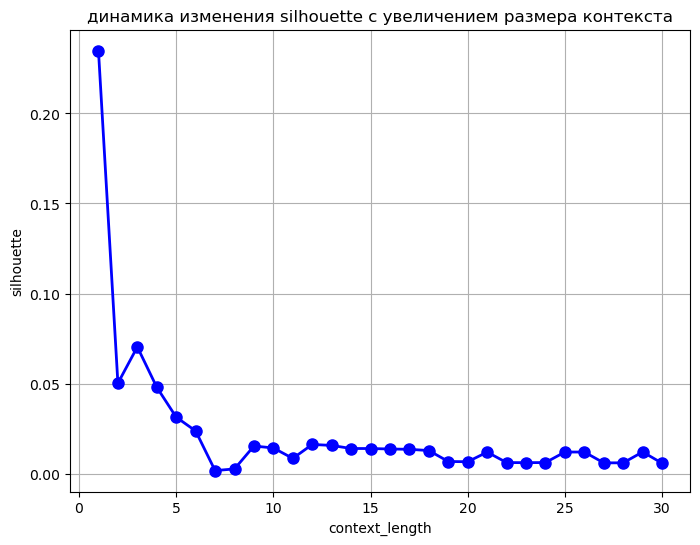

In [29]:
# кластеризация омографов с помощью K-means
print('K-means clustering')
score_k_means = main(df, kmeans_clustering)

# Строим график
plt.figure(figsize=(8, 6))
plt.plot(score_k_means['context_length'], score_k_means['silhouette'], 
         marker='o',  
         linestyle='-',  
         color='blue',
         linewidth=2,
         markersize=8)

# Подписи осей и заголовок
plt.xlabel('context_length')
plt.ylabel('silhouette')
plt.title('динамика изменения silhouette с увеличением размера контекста')
plt.grid(True)  

plt.show()